In [1]:
# depth_mapping.ipynb

# Python notebook for prototyping implementation for 3D depth mapping algorithm from the following paper:
# J. Wlodek, K. J. Gofron, Y. Q. Cai; Achieving 3D imaging through focus stacking.
# AIP Conf. Proc. 15 January 2019; 2054 (1): 050001. https://doi.org/10.1063/1.5084619

# Bennett Wu - 11/17/2023

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2

In [2]:
def normalize_array(img: np.array, uint8_mode=False) -> np.array:
    img = img.astype('float32')
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    if uint8_mode:
        img *= 255
        img = img.astype('uint8')
    return img


def load_image(path: os.PathLike) -> np.array:
    try:
        bgr_img = cv2.imread(path)
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        return normalize_array(rgb_img)
    except:
        raise Exception(f'Failed to load image: {path}')



def rgb_to_gray(im: np.array) -> np.array:
    return cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)



def plt_img(ax: plt.axis, img: np.array, title='') -> None:
    cmap = 'gray'
    if (len(img.shape) == 3 and img.shape[2] == 3):
        cmap = None
    ax.imshow(img, cmap=cmap)
    ax.axis('off')
    if title:
        ax.set_title(title)

In [3]:
img_dir = './test_images/'
img_names = [
    'hf001.jpg', 'hf005.jpg', 'hf010.jpg', 'hf015.jpg',
    'hf020.jpg', 'hf025.jpg', 'hf030.jpg', 'hf035.jpg',
    # '1.jpg', '2.jpg'
]

focal_depths = [
    1, 5, 10, 15, 20, 25, 30, 35
    # 1, 2
]

focal_depths = np.array(focal_depths)
images = np.array([load_image(os.path.join(img_dir, name))
                  for name in img_names])

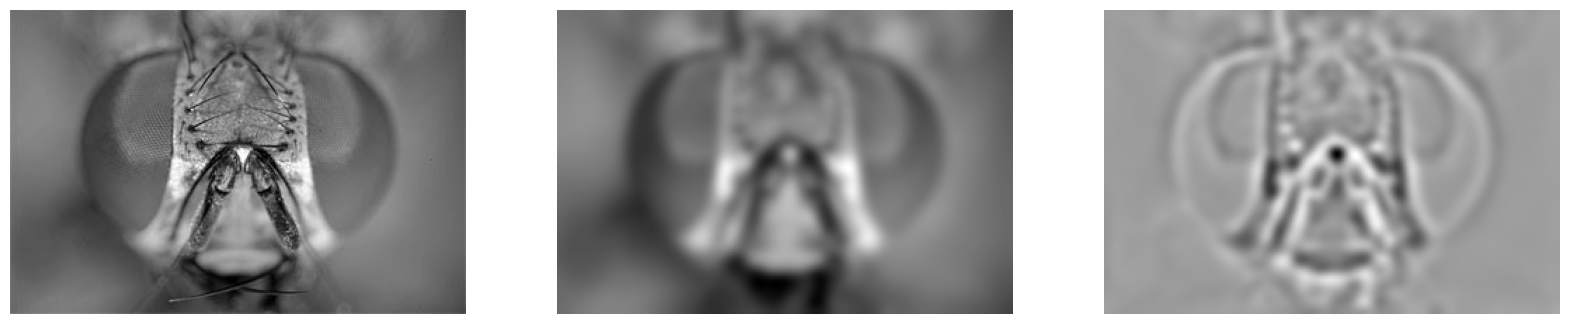

In [4]:
def gaussian_kernel(sigma: float, kernel_half_size: int) -> np.array:
    window_size = kernel_half_size*2+1
    gaussian_kernel_1d = sp.signal.windows.gaussian(
        window_size, std=sigma).reshape(window_size, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    gaussian_kernel_2d /= np.sum(gaussian_kernel_2d)

    return gaussian_kernel_2d


def gauss_convolve(im: np.array, ksize: int) -> np.array:
    assert ksize % 2 == 1  # ksize must be odd
    assert len(img.shape) == 2 or len(img.shape) == 3 # Grayscale or RGB images allowed
    return cv2.GaussianBlur(im, (ksize, ksize), 0)


def laplacian_convolve(im: np.array, ksize: int) -> np.array:
    assert ksize % 2 == 1  # ksize must be odd
    assert len(img.shape) == 2 or len(img.shape) == 3 # Grayscale or RGB images allowed
    return cv2.Laplacian(im, ddepth=cv2.CV_32F, ksize=ksize)

img = rgb_to_gray(images[3])
blur = gauss_convolve(img, 25)
sharp = laplacian_convolve(blur, 25)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
plt_img(ax[0], img)
plt_img(ax[1], blur)
plt_img(ax[2], sharp)

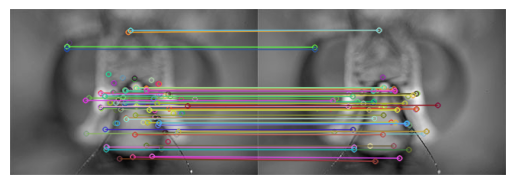

In [5]:
# Function adapted from https://github.com/bznick98/Focus_Stacking @ d61993a

# Note - This is not working well, a different approach may be needed

def align_images(images: list[np.array], max_features=1000, good_match_thresh=0.75):
    # use uint8 images for cv2.drawMatches()
    images = [normalize_array(img, uint8_mode=True) for img in images]

    ref = images[0]
    aligned_images = [ref]

    # find homography between other images and ref img
    match_images = []
    for img in images[1:]:
        height, width = img.shape

        detector = cv2.KAZE_create(max_features)

        # find keypoints and descriptors
        kp_a, des_a = detector.detectAndCompute(img, None)
        kp_b, des_b = detector.detectAndCompute(ref, None)

        # Matcher
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_a, des_b, k=2)

        # Apply ratio test
        good = []
        for m, n in matches:
            if m.distance < good_match_thresh*n.distance:
                good.append(m)
        numMatches = int(len(good))
        matches = good

        match_images.append(
            cv2.drawMatches(ref, kp_a, img, kp_b, matches, None)
        )

        # extract location of good matches
        pts_a = np.zeros((numMatches, 2), dtype=np.float32)
        pts_b = np.zeros((numMatches, 2), dtype=np.float32)

        for idx, match in enumerate(matches):
            pts_a[idx, :] = kp_a[match.queryIdx].pt
            pts_b[idx, :] = kp_b[match.trainIdx].pt

        H, _ = cv2.findHomography(pts_a, pts_b, cv2.RANSAC)

        img_warped = cv2.warpPerspective(img, H, (width, height))
        aligned_images.append(img_warped)

    return aligned_images, match_images

grayscale_img = [rgb_to_gray(img) for img in images]
aligned_images, match_images = align_images(grayscale_img)

plt_img(plt, match_images[0])

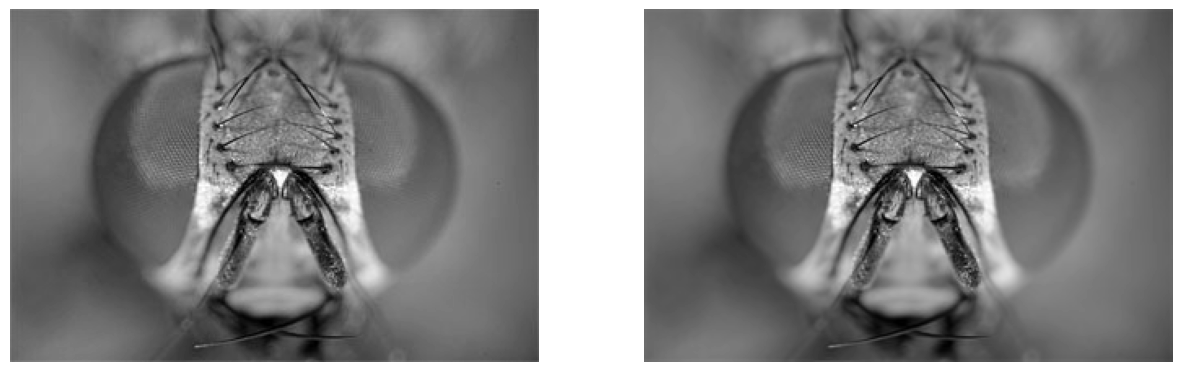

In [6]:
def denoise_image(img: np.array, template_win_size=7, search_win_size=21, filter_strength=10) -> np.array:
    assert template_win_size % 2 == 1  # Window sizes must be odd
    assert search_win_size % 2 == 1    # Window sizes must be odd
    assert len(img.shape) == 2 or len(img.shape) == 3 # Grayscale or RGB images allowed
    
    img = normalize_array(img, uint8_mode=True)
    img = cv2.fastNlMeansDenoising(img, None, template_win_size, search_win_size, filter_strength)
    return normalize_array(img)


img = images[3]
gray = normalize_array(rgb_to_gray(img), uint8_mode=True)
denoised = denoise_image(gray, 7, 21, 3)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], gray)
plt_img(ax[1], denoised)

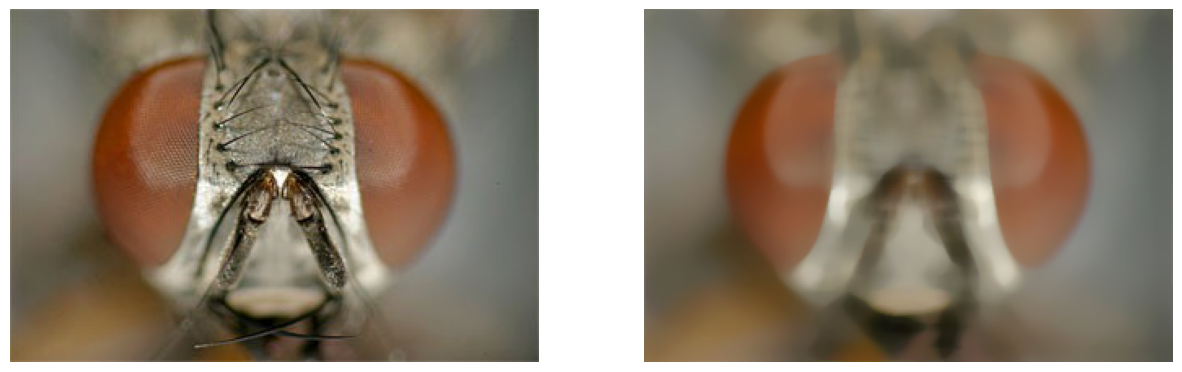

In [7]:
def smooth_image(img: np.array, kernel_size=7) -> np.array:
  assert kernel_size % 2 == 1 # Kernel size must be odd
  assert len(img.shape) == 2 or len(img.shape) == 3 # Grayscale or RGB images allowed

  img = normalize_array(img, uint8_mode=True)
  img = cv2.medianBlur(img, kernel_size)
  return img

img = images[3]
smoothed = smooth_image(img, 15)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], img)
plt_img(ax[1], smoothed)

In [8]:
class DepthMapArgs:
    def __init__(self):
        self
    gaussian_kernel_size: int
    laplacian_kernel_size: int
    merge_tile_size: int
    # max_align_features: int
    # good_feature_thresh: float
    denoise_temp_win_size: int
    denoise_search_win_size: int
    denoise_strength: int
    smooth_kernel_size: int

In [9]:
def sharpness_vals(grayscale_img: np.array, args: DepthMapArgs) -> np.array:
    assert args.gaussian_kernel_size % 2 == 1  # ksize must be odd
    assert args.laplacian_kernel_size % 2 == 1  # ksize must be odd

    sharp_values = []
    for image in grayscale_img:
        denoise = denoise_image(image, args.denoise_temp_win_size,
                                args.denoise_search_win_size, args.denoise_strength)
        blur = gauss_convolve(denoise, args.gaussian_kernel_size)
        sharp = laplacian_convolve(blur, args.laplacian_kernel_size)
        sharp_values.append(sharp)

    return np.array(sharp_values)


def depth_mapping(images: np.array, focal_depths: np.array, args: DepthMapArgs):
    # images, _ = align_images(
    #     images,
    #     args.max_align_features,
    #     args.good_feature_thresh
    # )
    assert len(np.unique(focal_depths)) ==  len(focal_depths) # Focal depths should be unique

    norm_depth = normalize_array(focal_depths, uint8_mode=True)

    grayscale_imgs = [rgb_to_gray(img) for img in images]
    sharp_values = sharpness_vals(grayscale_imgs, args)
    max_sharp = np.argmax(sharp_values, axis=0)

    tile_size = args.merge_tile_size
    num_img, height, width = sharp_values.shape
    stacked = np.zeros((height, width, 3))
    depth_map = np.zeros((height, width))

    for tile_r in range(0, height - tile_size, tile_size):
        for tile_c in range(0, width - tile_size, tile_size):
            tile_sharp = sharp_values[
                :,
                tile_r: tile_r+tile_size,
                tile_c: tile_c+tile_size
            ]

            arg_max = 0
            max_sharp = np.max(tile_sharp[0])
            for i in range(1, tile_sharp.shape[0]):
                if np.max(tile_sharp[i]) > max_sharp:
                    arg_max = i
                    max_sharp = np.max(tile_sharp[i])
            for r in range(tile_r, tile_r + tile_size):
                for c in range(tile_c, tile_c + tile_size):
                    depth_map[r, c] = norm_depth[arg_max]
    
    depth_map = smooth_image(depth_map, args.smooth_kernel_size)
    masks = []
    for depth in norm_depth:
        masks.append(depth_map == depth)

    for i in range(len(masks)):
        for j in range(3):
            stacked[:, :, j] += masks[i] * images[i, :, :, j]

    return depth_map, stacked

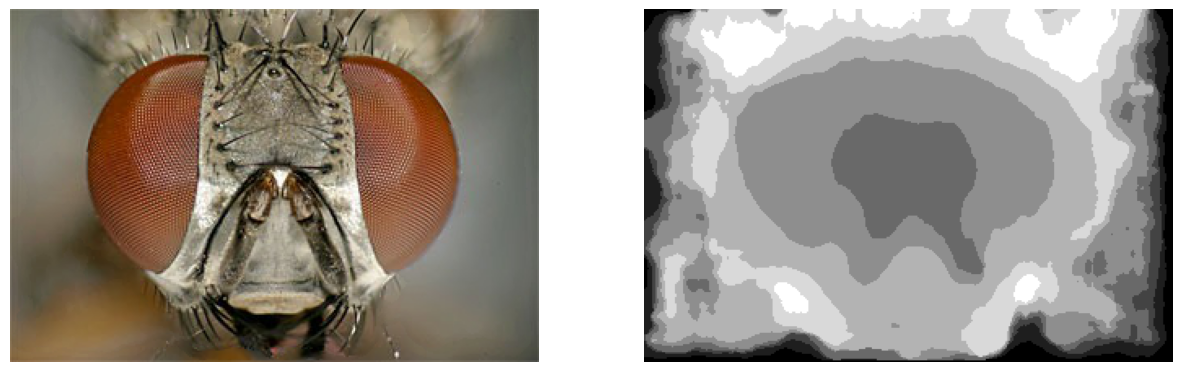

In [10]:
args = DepthMapArgs()
args.gaussian_kernel_size = 3
args.laplacian_kernel_size = 3
args.merge_tile_size = 3
# args.max_align_features = 10000
# args.good_feature_thresh = 0.85
args.denoise_temp_win_size = 7
args.denoise_search_win_size = 21
args.denoise_strength = 3
args.smooth_kernel_size = 25

depth, stack = depth_mapping(images, focal_depths, args)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], stack)
plt_img(ax[1], depth)